## Daily Fantasy Football: Robust Optimization

This notebook is the home of the code which runs the fantasy football optimizer under both the robust and MILP paradigms and compares them. Most functions are actually written in the `opt_functions.py` file. Documentation on how those functions work can be found in that file.

The results will be generated by assuming that the errors are roughly normally distributed with mean of 0 and covariance that is generated according to algorithm 1 in the accompanying paper. The "true" errors are assumed to be the errors that come from a covariance matrix that uses all 18 weeks of data for which a user would never have that information to make decisions. Then a robust optimization is run using only the weeks leading up to whatever week is specified and a MILP optimization is run  to generate two separate lineups. 

In [12]:
#Install Dependencies
import os.path
import pandas as pd
import numpy as np
from scipy import stats, linalg
import matplotlib.pyplot as plt
from nearest_correlation import nearcorr
import gurobipy as gp
from gurobipy import *
from distfit import distfit
from opt_functions import *

In [2]:
#Read dfs_forecast data
current_path = os.getcwd()
udfs_data_path = os.path.dirname(current_path) + "\Data\\udfs_data2021.csv"
udfs_data = pd.read_csv(udfs_data_path)

#Remove players who did not play
udfs_data = udfs_data.loc[(udfs_data["DK points"] != 0) | (udfs_data["Pos"] == "DST")]
udfs_data

,Year,Week,Name,Pos,Team,ProjDKPts,ProjFDPts,Team2,Oppt,DK points,DK salary,error
0,2021,1,Christian McCaffrey,RB,Panthers,23.34,19.86,car,nyj,27.70,9500,4.36
1,2021,1,Dalvin Cook,RB,Vikings,22.18,19.15,min,cin,21.40,9100,-0.78
2,2021,1,Derrick Henry,RB,Titans,19.99,17.60,ten,ari,10.70,8800,-9.29
3,2021,1,Jonathan Taylor,RB,Colts,15.65,13.84,ind,sea,17.60,8000,1.95
4,2021,1,Calvin Ridley,WR,Falcons,20.38,15.99,atl,phi,10.10,7900,-10.28
...,...,...,...,...,...,...,...,...,...,...,...,...
17850,2021,18,Mekhi Sargent,RB,Jaguars,0.00,0.00,jac,ind,0.20,4000,0.20
17927,2021,18,Dazz Newsome,WR,Bears,0.00,0.00,chi,min,2.30,3000,2.30
18001,2021,18,Mitchell Trubisky,QB,Bills,0.00,0.00,buf,nyj,0.30,5000,0.30
18009,2021,18,Trevor Siemian,QB,Saints,0.00,0.00,nor,atl,10.74,4600,10.74


### Generating the covariance matrices
The objective function to the robust version of the daily fantasy football problem is:

$$\max_{x}p^{T}x-\rho\|\Sigma_e^\frac{1}{2}x\|$$

Where $\Sigma$ is the covariance matrix of the errors for the model. As such $\Sigma$ needs to be generated from the dataset. There are two sets of covaariance matrices that will be generated, one that will include errors for all weeks which will be used to generate the actual errors for the simulation and one that will be used in the actual optimization problem to select the lineup. The next three cells then do the following:

1. The first cell completes the first half of algorithm 1 which populates the initial correlation matrices for players on the same team. 
2. The second cell completes the initial correlation matrices for players on opposing teams in the specified weeks. 
3. The third cell uses Mike Croucher's implementation of Nick Higham's nearrest correlation algorithm to ensure that the correlation matrices are positive semi definite. 
4. The correlation matrices are then converted back to covariance matrices using the equation $\Sigma_e = D_eR_eD_e$. Where $D_e$ is the diagonalized error standard deviation matrix and $R_e$ is the error correlation matrix. _Equation 24 in the paper_
5. Finally lines 5 and 7 of the third cell add a very small decimall to the diagonal of the covariance matrix. Due to floating point arithmetic, the coavriance matrices might be slightly off from PSD and this addition ensures that the covariance matrices are indeed PSD.

In [3]:
#Create roster and inital matrix information for players on the same team

year = 2021 # Year for lineup optimization
week = 15 # Week for lineup optimization
calc_data = udfs_data # Data to be used for lineup optimization
roster, same_cor, roster_var, sim_same_cor, sim_var = gen_same_team_cor(calc_data, year, week) #Simulation and lineup optimization correlation matrices for players on the same team 

In [4]:
#Update matrix information to include players on competing teams

init_cor = gen_opp_team_cor(calc_data, same_cor, roster, year, week) # Update lineup optimization correlation matrix with players on opposing teams 
init_cor_sim = gen_opp_team_cor_sim(calc_data, sim_same_cor, roster, year, week) # Update simulation correlation matrix with players on opposing teams 

In [5]:
#Find nearest correlation matrix then update to covariance matrix

final_cor = nearcorr(init_cor) # Find nearrest correlation matrix for linuep optimization correlation matrix
final_cor_sim = nearcorr(init_cor_sim) # Find nearrest correlation matrix for simulation correlation matrix
interm_cov = np.diag(np.sqrt(roster_var)) @ final_cor @ np.diag(np.sqrt(roster_var)) # Convert lineup optimization correlation matrix to a covariance matrix
final_cov = interm_cov + (.0000001 * np.eye(interm_cov.shape[0])) # Add small adjustment for rounding errors
interm_cov_sim = np.diag(np.sqrt(sim_var)) @ final_cor_sim @ np.diag(np.sqrt(sim_var)) # Convert simulation correlation matrix to a covariance matrix
final_cov_sim = interm_cov_sim + (.0000001 * np.eye(interm_cov_sim.shape[0])) # Add small adjustment for rounding errors

In [6]:
#Extract relevant information for the optimization problems

pos_dict = get_pos_indices(calc_data, roster, year, week) # Dictionary with position as keys and the list of indices corresponding to the set of possible players for each position
projections = get_projections(calc_data, roster, year, week) # list of projections for the set of possible players
points = get_points(calc_data, roster, year, week) # List of actual points scored for the set of possible players
costs = get_costs(calc_data, roster, year, week) # List of costs for the set of possible players
errors = get_errors(calc_data, roster, year, week) # List of errors for the set of possible players
exclude = [] # Players to exclude from lineup selection

### Running the simulation

The next cell carries out the following steps:
1. 10,000 samples are drawn from the error multivariate gaussian specified by mean of 0 and covariance matrix that was generated in the previous section.
2. Solutions are generated for both the robust optimization and MILP paradigms
3. The errors that were sampled then get added to the projections for each lineup to return point distributions

In [7]:
#Run simulation of 10,000 attempts and record results
np.random.seed(10000)
rho = 1
sim_errors = np.random.multivariate_normal(mean=np.zeros(len(roster)), cov=final_cov_sim, size = 10000)
milp_results = []
robust_results = []
milp_solution = MILP(projections, costs, pos_dict, exclude)
robust_solution = Robust(projections, costs, pos_dict, exclude, final_cov, rho, "polygon")
for i in range(sim_errors.shape[0]):
    milp_actual = sum([(projections[j] + sim_errors[i, j]) for j in range(len(milp_solution[1])) if milp_solution[1][j] > 0.5])
    robust_actual = sum([(projections[j] + sim_errors[i, j]) for j in range(len(robust_solution[1])) if robust_solution[1][j] > 0.5])
    milp_results.append(milp_actual)
    robust_results.append(robust_actual)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-24
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7 rows, 188 columns and 564 nonzeros
Model fingerprint: 0x386065e3
Variable types: 0 continuous, 188 integer (188 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 92.1100000
Presolve removed 0 rows and 42 columns
Presolve time: 0.00s
Presolved: 7 rows, 146 columns, 425 nonzeros
Variable types: 0 continuous, 146 integer (146 binary)
Found heuristic solution: objective 133.7100000

Root relaxation: objective 1.431341e+02, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

In [8]:
#View Lineups
milp_lineup = return_names(roster, milp_solution[1])
print(milp_lineup)
robust_lineup = return_names(roster, robust_solution[1])
print(robust_lineup)

['Christian Kirk', 'Kyler Murray', 'Bills', 'Gabriel Davis', 'Dalvin Cook', 'Justin Jefferson', 'James Robinson', 'David Njoku', 'Michael Carter']
['Kyler Murray', 'Bills', 'Cole Beasley', 'Gabriel Davis', 'Chris Godwin', 'Leonard Fournette', 'Mike Gesicki', 'James Robinson', 'Michael Carter']


### Visualize the results

The following three cells visualize the results. Using the distfit library, normal distributions are fit to the results of the simulations for the robust and MILP lineups. Lastly, the distributions are overlaid and lines are drawn at the 1% points to directly compare the two outcomes!

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm] [0.00 sec] [RSS: 9.9998e-06] [loc=143.151 scale=24.819]
[distfit] >Compute confidence interval [parametric]


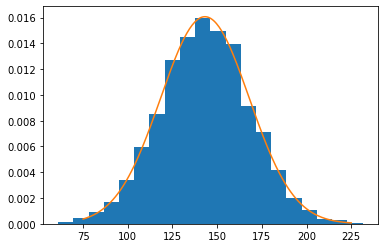

In [9]:
#Fit probability density function to MILP

dist = distfit()
distribution_data = milp_results
dist_norm = distfit(distr=['norm'])
milp_norm = dist_norm.fit_transform(np.array(distribution_data))
milp_x = np.linspace(75, 225, num=200)
milp_y = stats.norm.pdf(milp_x, milp_norm["model"]["loc"], milp_norm["model"]["scale"])
plt.hist(milp_results, 20, density=True)
plt.plot(milp_x, milp_y, label = "Normal Distribution")

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm] [0.00 sec] [RSS: 1.03037e-05] [loc=141.835 scale=19.272]
[distfit] >Compute confidence interval [parametric]


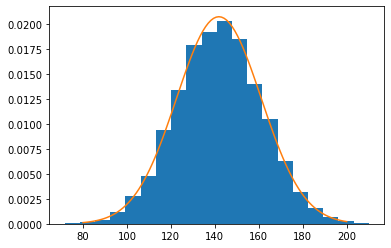

In [10]:
#Fit probability density function to Robust
dist = distfit()
distribution_data = robust_results
dist_norm = distfit(distr=['norm'])
robust_norm = dist_norm.fit_transform(np.array(distribution_data))
robust_x = np.linspace(80, 200, num=100)
robust_y = stats.norm.pdf(robust_x, robust_norm["model"]["loc"], robust_norm["model"]["scale"])
plt.hist(robust_results, 20, density=True)
plt.plot(robust_x, robust_y, label = "Normal Distribution")

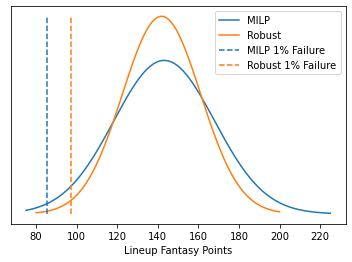

In [11]:
#Visually compare results
milp_line = stats.norm.ppf(.01, loc=milp_norm["model"]["loc"], scale=milp_norm["model"]["scale"])
robust_line = stats.norm.ppf(.01, loc=robust_norm["model"]["loc"], scale=robust_norm["model"]["scale"])

plt.plot(milp_x, milp_y, label = "MILP")
plt.plot(robust_x, robust_y, label = "Robust")
plt.plot([milp_line]*2, [0, np.max(robust_y)], linestyle="--", color="tab:blue")
plt.plot([robust_line]*2, [0, np.max(robust_y)], linestyle="--", color="tab:orange")
plt.legend(["MILP", "Robust", 'MILP 1% Failure', 'Robust 1% Failure'])
plt.xlabel("Lineup Fantasy Points")

ax = plt.gca()
ax.get_yaxis().set_visible(False)